# ISMI - BrainTriage - Angry Chickens

# Import packages

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as math
import csv
import pandas as pd

from tqdm.notebook import tqdm
import pdb

pd.set_option('display.max_rows', 500)

# Global notebook parameters

In [59]:
extract_slices = False         # Whether to run the data creation to generate slice data

# Extract slices from dataset
We only have to extract the slices once so I decide to extract all slices. The resolution is 32x3x512x512, so we can assume each patient has 32 slices.

In [60]:
IN_DIR = '../data/BrainTriage/train/full'
DATA_DIR = '../data/BrainTriage/sliced_data'

def generate_slice_data():
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)

    patients = []
     
    for klass in os.listdir(IN_DIR):
        for patient in tqdm(os.listdir(os.path.join(IN_DIR, klass)), desc="Patients"):
            
            ## Check if patient has not been processed yet
            if patient not in patients:
                ## Paths to the image files
                t1_path = os.path.join(IN_DIR, klass, patient,'T1.mha')
                t2_path = os.path.join(IN_DIR, klass, patient,'T2.mha')
                t2_flair_path = os.path.join(IN_DIR, klass, patient,'T2-FLAIR.mha')

                ## Load all images as numpy arrays
                t1_array = sitk.GetArrayFromImage(sitk.ReadImage(t1_path))
                t2_array = sitk.GetArrayFromImage(sitk.ReadImage(t2_path))
                t2_flair_array = sitk.GetArrayFromImage(sitk.ReadImage(t2_flair_path))
                
                n_slices = t1_array.shape[0]
                
                for slice_number in range(n_slices):

                    with open(DATA_DIR+'/labels_slices.csv', 'a') as csvfile:      
                        w = csv.writer(csvfile, delimiter=',')
                        ## Write 0 if "normal", 1 if "abnormal"
                        w.writerow([patient, slice_number, klass == "abnormal"])

                    t1_slice = t1_array[slice_number,:,:]
                    t2_slice = t2_array[slice_number,:,:]
                    t2_flair_slice = t2_flair_array[slice_number,:,:]
                    comb_data = np.array([t1_slice, t2_slice, t2_flair_slice])

                    ## Save as torch tensor for quick loading during training
                    torch.save(torch.from_numpy(comb_data.astype('float32')), os.path.join(DATA_DIR, f"{patient}_{slice_number}.pt"))
            else:
                continue
                
            patients.append(patient)

In [61]:
if extract_slices:
    generate_slice_data()

## Test whether the created dataframe makes sense

In [62]:
label_df = pd.read_csv(os.path.join(DATA_DIR,"labels_slices.csv"), names = ["patient_nr", "slice_nr", "class"])
label_df["class"] = label_df["class"].astype("int8")
patient_list = np.unique(label_df["patient_nr"])
print(label_df.head(), f"Dataframe shape: {label_df.shape}", sep="\n")
print(f"\nNumber of unique patient numbers: {len(np.unique(label_df['patient_nr']))}")
print(f"Number of unique slice numbers:   {len(np.unique(label_df['slice_nr']))}")
print(f"Number of unique class values:    {len(np.unique(label_df['class']))}")

   patient_nr  slice_nr  class
0         797         0      1
1         797         1      1
2         797         2      1
3         797         3      1
4         797         4      1
Dataframe shape: (32000, 3)

Number of unique patient numbers: 1000
Number of unique slice numbers:   32
Number of unique class values:    2


## Visually inspect (a range of) slices

In [94]:
def plot_slices(patient, range_of_slices):
    """
        Plots a tuple/list of slices with ceil(sqrt(n_slices)) rows and cols
        OR
        Plots a single slice
    """
    if type(range_of_slices) == tuple or type(range_of_slices) == list:
        # Determine the number of slices that need to be displayed
        if type(range_of_slices) == tuple:
            lower, upper = range_of_slices
            n_slices = upper - lower + 1
        else:
            n_slices = len(range_of_slices)
            
        # Determine the number of rows, columns and subplots to be deleted
        if n_slices < 4:
            n_rows = 1; n_cols = n_slices
        else:
            n_rows = n_cols = math.ceil(math.sqrt(n_slices))
        n_delete_subplots = n_rows * n_cols - n_slices
        
        # Loop over all slices in the datastructure and display them
        fig, axes = plt.subplots(n_rows, n_cols, figsize = (16, 16))
        iterable = range(lower, upper+1) if type(range_of_slices) == tuple else range_of_slices
        for i, slice_nr in enumerate(iterable):
            X = torch.load(os.path.join(DATA_DIR, f"{patient}_{slice_nr}.pt"))
            ax = axes[i // n_rows, i % n_cols] if n_rows > 1 else axes[i]
            
            ax.imshow(X.data.numpy()[2,:,:])
            ax.set_title(f"Patient {patient}: slice {slice_nr}")
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        
        # Remove empty plots
        for i in range(n_slices, n_slices + n_delete_subplots):
            if n_rows > 1:
                fig.delaxes(axes[i // n_rows][i % n_cols])
            else:
                fig.delaxes(axes[i % n_cols])
    else:
        # Plot a single slice
        slice_nr = range_of_slices
        X = torch.load(os.path.join(DATA_DIR, f"{patient}_{slice_nr}.pt"))
        plt.figure()
        plt.imshow(X.data.numpy()[2,:,:]) 
        plt.title(f"Patient {patient}: slice {slice_nr}")
        plt.xticks([], [])
        plt.yticks([], [])
    plt.show()

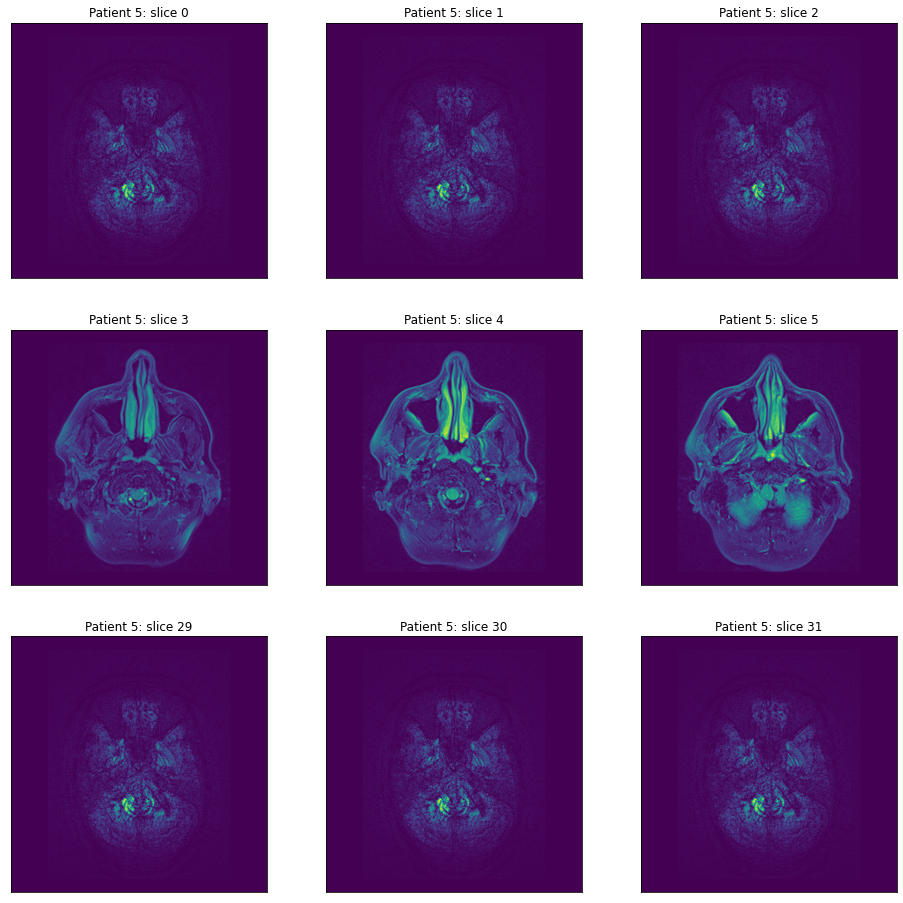

In [96]:
plot_slices(5,[0,1,2,3,4,5,29,30,31])

# Dataset logic
## Train/Validation split functions for label dataframes

In [11]:
def get_slice_train_val_dataframes(label_df, train_percentage=0.8):
    """
        Generates an evenly class-distributed train/val split for all slices in the dataset, 
        regardless of the patient number.
    """
    # Sort values on class, because we know the first half is 0 and the second half is 1
    temp_label_df = label_df.sort_values("class")

    n_slices_per_class = temp_label_df.shape[0]//2
    normal_indices = np.random.permutation(n_slices_per_class)
    abnormal_indices = np.random.permutation(n_slices_per_class) + n_slices_per_class

    # Split the patient lists into train and validation (index must be in list to split in two parts)
    split_idx = int(train_percentage * n_slices_per_class)
    normal_train_indices, normal_val_indices = np.split(normal_indices, [split_idx])
    abnormal_train_indices, abnormal_val_indices = np.split(abnormal_indices, [split_idx])

    # Append train and validation dataframes 
    train_df = temp_label_df.iloc[normal_train_indices].append(temp_label_df.iloc[abnormal_train_indices])
    val_df = temp_label_df.iloc[normal_val_indices].append(temp_label_df.iloc[abnormal_val_indices])

    return train_df, val_df

def get_patient_train_val_dataframes(label_df, train_percentage=0.8):
    """
        Creates an evenly class-distributed train/val split for all patients in the dataset.
        Target slices are taken into account in the Dataset classes.
    """
    # Generate dataframe that maps patient_nr to class
    temp_label_df = label_df.drop("slice_nr",axis=1).drop_duplicates()
    # Sort values to get patient_list in same order as patient_nr col in dataframe
    temp_label_df = temp_label_df.sort_values("patient_nr")
    patient_list = np.unique(temp_label_df["patient_nr"])

    abnormal_patients = patient_list[np.where(temp_label_df["class"].values)[0]]
    # Shuffle patient_list for random train/val split (only in-place)
    np.random.shuffle(abnormal_patients)
    normal_patients = np.setdiff1d(patient_list, abnormal_patients)
    # np.setdiff1d returns a sorted array, so shuffle normal patients too
    np.random.shuffle(normal_patients)

    # Split the patient lists into train and validation (index must be in list to split in two parts)
    n_patients_per_class = patient_list.shape[0]/2
    split_idx = int(train_percentage * n_patients_per_class)
    normal_train_patients, normal_val_patients = np.split(normal_patients, [split_idx])
    abnormal_train_patients, abnormal_val_patients = np.split(abnormal_patients, [split_idx])

    # Append train and validation dataframes 
    train_df = label_df[label_df["patient_nr"].isin(normal_train_patients)] \
                .append(label_df[label_df["patient_nr"].isin(abnormal_train_patients)])
    val_df = label_df[label_df["patient_nr"].isin(normal_val_patients)] \
                .append(label_df[label_df["patient_nr"].isin(abnormal_val_patients)])

    # Create training and validation patient lists
    train_patients = np.append(normal_train_patients, abnormal_train_patients)
    val_patients = np.append(normal_val_patients, abnormal_val_patients)
    
    return train_df, val_df, train_patients, val_patients

## Dataset classes for the slice and patient datasets

In [12]:
class SliceDataset(data.Dataset):
    """
        Used only for CNN training
    """
    def __init__(self, label_df, target_slices):
        if type(target_slices) == tuple:
            self.label_df = label_df[label_df["slice_nr"].isin(range(*target_slices))]
        elif type(target_slices) == list:
            self.label_df = label_df[label_df["slice_nr"].isin(target_slices)]
        else:
            self.label_df = label_df[label_df["slice_nr"] == target_slices]
        
    def __len__(self):
        return self.label_df.shape[0]
    
    def __getitem__(self, index):
        patient_nr, slice_nr, cls = self.label_df.iloc[index].to_numpy()
        y = cls
        X = torch.load(os.path.join(DATA_DIR, f"{patient_nr}_{slice_nr}.pt"))
        
        return X, y
        
    
class PatientDataset(data.Dataset):
    """
        Used for combination training, so 
            (1) LSTM separately and 
            (2) finetuning phase of CNN and LSTM together
    """
    def __init__(self, label_df, patient_list, target_slices):
        self.label_df = label_df
        self.patient_list = patient_list
        self.target_slices = target_slices
        
    def __len__(self):
        return self.patient_list.shape[0]
    
    def __getitem__(self, index):
        patient_nr = self.patient_list[index]
        
        if type(self.target_slices) == tuple:
            slice_list = [self.get_slice_tensor(patient_nr, slice_nr) for slice_nr in range(*self.target_slices)]
        elif type(self.target_slices) == list:
            slice_list = [self.get_slice_tensor(patient_nr, slice_nr) for slice_nr in self.target_slices]
        else: # If single integer
            slice_list = [self.get_slice_tensor(patient_nr, self.target_slices)]
        
        X = torch.stack(slice_list)
        y = self.label_df[self.label_df["patient_nr"] == patient_nr].iloc[0,2]
        
        return X, y
    
    def get_slice_tensor(self, patient_nr, slice_nr):
        return torch.load(os.path.join(DATA_DIR, f"{patient_nr}_{slice_nr}.pt"), map_location=DEVICE)

# Network classes
## Fully connected model for Feature extraction
This will later be replaced by a pre-trained network (like ResNet).

In [13]:
class FeatureVectorModel(nn.Module):
    def __init__(self, n_features):
        super(FeatureVectorModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(512*512*3, 256)
        self.feature_linear = nn.Linear(256, n_features)
        self.classification_linear = nn.Linear(n_features, 1)
        # For saving model and loss values
        self.name = "FCNet" 
        
    def forward(self, x):
        h = self.linear_1(self.flatten(x))
        h = self.feature_linear(h)
        h = self.classification_linear(h)
        # We don't need Softmax when using BCEWithLogitsLoss
        return torch.squeeze(h)
        

## LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, 
                            num_layers=n_layers, batch_first=True)
        self.classification_linear = nn.Linear(n_hidden,1)
        # For saving model and loss values
        self.name = "LSTMNet" 
        
    def forward(self, x):
        lstm_output, (_, _) = self.lstm(x)
        output = self.classification_linear(lstm_output[:,-1])
        return torch.squeeze(output)

## CombinedNet

In [15]:
class CombinedNet(nn.Module):
    def __init__(self, cnn_net, lstm_net, do_freeze_fc_net=False):
        super(CombinedNet, self).__init__()
        # Remove classification layer from FC network
        self.cnn_net = torch.nn.Sequential(*(list(cnn_net.children())[:-1]))
        self.lstm_net = lstm_net
        # For saving model and loss values
        self.name = "CombinedNet" 
    
    def forward(self, batch_of_patients):
        # Loop over all slices and compute feature vectors with cnn_net
        feature_vectors = [self.cnn_net(batch_of_slices) for batch_of_slices in batch_of_patients]
        feature_vectors = torch.stack(feature_vectors)

        # Convert to Tensor and compute predictions with LSTM net
        prediction = self.lstm_net(feature_vectors)
        
        return prediction

    def set_learning_cnn_net(self, do_learning):
        for param in self.cnn_net.parameters():
                param.requires_grad = do_learning

# Training and Validation

## Functions

In [ ]:
def train(model, loss, optimizer, train_loader, batch_size, loss_history, acc_history):
    loss_history['training'].append(0)
    acc_history['training'].append(0)

    for batch_idx, (images, targets) in tqdm(enumerate(train_loader), total=len(training_set)//(batch_size+1), desc="#train_batches", leave=False):
        model.train()
        optimizer.zero_grad()

        images = images.float()
        targets = targets.float()

        predictions = model(images)
        loss = criterion(predictions, targets)
        loss.backward()

        optimizer.step()

        #Accuracy
        accuracy_predictions = (torch.sigmoid(predictions)>0.5).float()

        correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]

        loss_history['training'][-1] += float(loss.data)
        acc_history['training'][-1] += float(correct)

    loss_history['training'][-1] /= batch_idx + 1
    acc_history['training'][-1] /= batch_idx + 1
    
def validate(model, loss, val_loader, batch_size, loss_history, acc_history):
    loss_history['validation'].append(0)
    acc_history['validation'].append(0)

    for batch_idx, (images, targets) in tqdm(enumerate(val_loader), total=len(validation_set)//(batch_size+1), desc="#test_batches", leave=False):
        model.eval()

        images = images.float()
        targets = targets.float()

        predictions = model(images)
        loss = criterion(predictions, targets)

        #Accuracy
        accuracy_predictions = (torch.sigmoid(predictions)>0.5).float()
        correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]

        loss_history['validation'][-1] += float(loss.data)
        acc_history['validation'][-1] += float(correct)

    loss_history['validation'][-1] /= batch_idx + 1
    acc_history['validation'][-1] /= batch_idx + 1

In [17]:
def train_and_validate(model, loss, optimizer, train_loader, val_loader, batch_size, n_epochs=1):
    print(f'Running {model.name}')

    ### Training and validation ###
    loss_history = {'training': [], 'validation': []}
    acc_history = {'training': [], 'validation': []}
    best_val_loss = 9999999

    for epoch in tqdm(range(n_epochs), desc="#epochs"):
        train(model, loss, optimizer, train_loader, batch_size, loss_history, acc_history)

        validate(model, loss, val_loader, batch_size, loss_history, acc_history)
        
        if loss_history['validation'][-1] < best_val_loss:
            best_val_loss = loss_history['validation'][-1]
            torch.save(model.state_dict(), '{:s}/{:s}_{:03d}.npz'.format(model_dir, model.name, epoch))

        print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.3f}, validation accuracy: {:.3f}.'.format(epoch + 1, epochs, loss_history['training'][-1], loss_history['validation'][-1], acc_history['training'][-1], acc_history['validation'][-1]))
        np.savez('{:s}/{:s}_loss_history_{:03d}.npz'.format(model_dir, model.name, epoch), loss_history)

## Global train/validation parameters

In [16]:
### Parameters ###
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on GPU or CPU
TARGET_SLICES = 14                                       # The slices we will train on for each patient
N_FEATURES = 128                                         # The length of feature vectors that the CNN outputs/LSTM will use
TRAIN_PERCENTAGE = 0.9                                   # Percentage of data that will be used for training

## CNN network

### CNN-specific parameters

In [18]:
### Parameters ###
epochs = 1
batch_size = 2
n_features = 128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
fc_net = FeatureVectorModel(n_features=n_features)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
train_df, val_df = get_slice_train_val_dataframes(label_df, train_percentage = TRAIN_PERCENTAGE)

training_set = SliceDataset(train_df, TARGET_SLICES)
validation_set = SliceDataset(val_df, TARGET_SLICES)

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

### Train and validate CNN

In [19]:
train_and_validate(model=fc_net, loss=criterion, optimizer=optimizer, 
                   train_loader=training_iterator, val_loader=validation_iterator, 
                   batch_size=batch_size, n_epochs=epochs)

Running FCNet


RuntimeError: result type Float can't be cast to the desired output type Long

## LSTM network
### LSTM-specific parameters

In [46]:
### Parameters ###
epochs = 1
batch_size = 2
n_hidden = 64

### Create model ###
lstm_net = LSTM(n_features = N_FEATURES, n_hidden = n_hidden, n_layers = 1)
combined_net = CombinedNet(cnn_net = fc_net, lstm_net = lstm_net)
# Turn off learning for cnn_net
combined_net.set_learning_cnn_net(False)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
train_df, val_df, train_patients, val_patients = get_patient_train_val_dataframes(label_df, train_percentage = TRAIN_PERCENTAGE)

# The training/validation sets will be used again for CombinedNet, but new DataLoaders will be created
# such that the data loading process starts from the beginning again
training_set = PatientDataset(train_df, train_patients, TARGET_SLICES)
validation_set = PatientDataset(val_df, val_patients, TARGET_SLICES)

training_iterator = data.DataLoader(training_set, batch_size = batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size = batch_size, shuffle = False)

       patient_nr  slice_nr  class
16000        1069         0      0
16001        1069         1      0
16002        1069         2      0
16003        1069         3      0
16004        1069         4      0
       patient_nr  slice_nr  class
16032         909         0      0
16033         909         1      0
16034         909         2      0
16035         909         3      0
16036         909         4      0


### Train and validate LSTM

In [47]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


Batch 0
images: torch.Size([2, 2, 3, 512, 512])
target: tensor([1, 1], dtype=torch.int8)
target: (2,)
torch.Size([2, 2, 3, 512, 512])
torch.Size([2, 2, 128])
LSTM
preds:  torch.Size([2])
preds:  tensor([-0.1501, -0.1465], grad_fn=<SqueezeBackward0>)
Batch 1
images: torch.Size([2, 2, 3, 512, 512])
target: tensor([0, 0], dtype=torch.int8)
target: (2,)
torch.Size([2, 2, 3, 512, 512])
torch.Size([2, 2, 128])
LSTM
preds:  torch.Size([2])
preds:  tensor([-0.1485, -0.1449], grad_fn=<SqueezeBackward0>)
Batch 2
images: torch.Size([2, 2, 3, 512, 512])
target: tensor([1, 0], dtype=torch.int8)
target: (2,)
torch.Size([2, 2, 3, 512, 512])
torch.Size([2, 2, 128])
LSTM
preds:  torch.Size([2])
preds:  tensor([-0.1485, -0.1449], grad_fn=<SqueezeBackward0>)
Batch 3
images: torch.Size([2, 2, 3, 512, 512])
target: tensor([1, 1], dtype=torch.int8)
target: (2,)
torch.Size([2, 2, 3, 512, 512])
torch.Size([2, 2, 128])
LSTM
preds:  torch.Size([2])
preds:  tensor([-0.1484, -0.1484], grad_fn=<SqueezeBackward0>)


KeyboardInterrupt: 

## CombinedNet
### CombinedNet-specific parameters

In [50]:
### Parameters ###
epochs = 1
batch_size = 32

# Turn learning for cnn_net back on
combined_net.set_learning_cnn_net(True)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

### Train and validate CombinedNet

In [ ]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


Batch 0
images: torch.Size([32, 2, 3, 512, 512])
target: tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1], dtype=torch.int8)
target: (32,)
torch.Size([32, 2, 3, 512, 512])
torch.Size([32, 2, 128])
LSTM
preds:  torch.Size([32])
preds:  tensor([-0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415,
        -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415,
        -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415,
        -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415, -0.1415],
       grad_fn=<SqueezeBackward0>)
Batch 1
images: torch.Size([32, 2, 3, 512, 512])
target: tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1], dtype=torch.int8)
target: (32,)
torch.Size([32, 2, 3, 512, 512])
torch.Size([32, 2, 128])
LSTM
preds:  torch.Size([32])
preds:  tensor([-0.1431, -0.1431, -0.1431, -0.1431, -0.1